# Task 2

### Libraries

In [1]:
!pip install datasets torch tensorflow transformers scikit-learn -q

In [2]:
from PIL import Image

# evalutation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tqdm.notebook import tqdm
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoImageProcessor, ResNetForImageClassification

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.init as init

from datasets import load_dataset

import tensorflow as tf
from keras.utils import plot_model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Defining useful directories

In [4]:
BASE_DIR = r"/content/drive/MyDrive/stt-05"

In [5]:
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

In [6]:
AUG_DIR = os.path.join(BASE_DIR, "augmented")

## Loading the Model

In [7]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Inspecting the model parameters and architecture

In [8]:
print(f'Total number of parameters: {sum(p.numel() for p in model.parameters())}')

Total number of parameters: 25557032


In [9]:
model_tf = tf.keras.applications.ResNet50(include_top = True)

In [10]:
model_tf.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

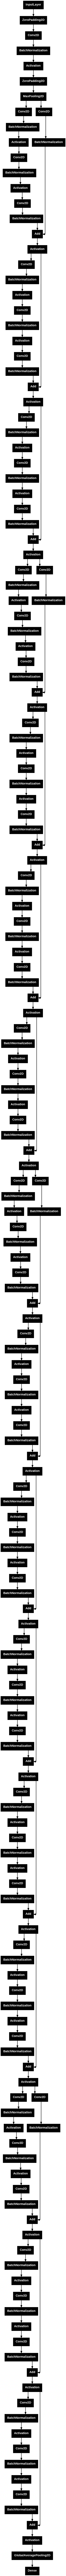

In [11]:
plot_model(model_tf)

### Architecture Diagram
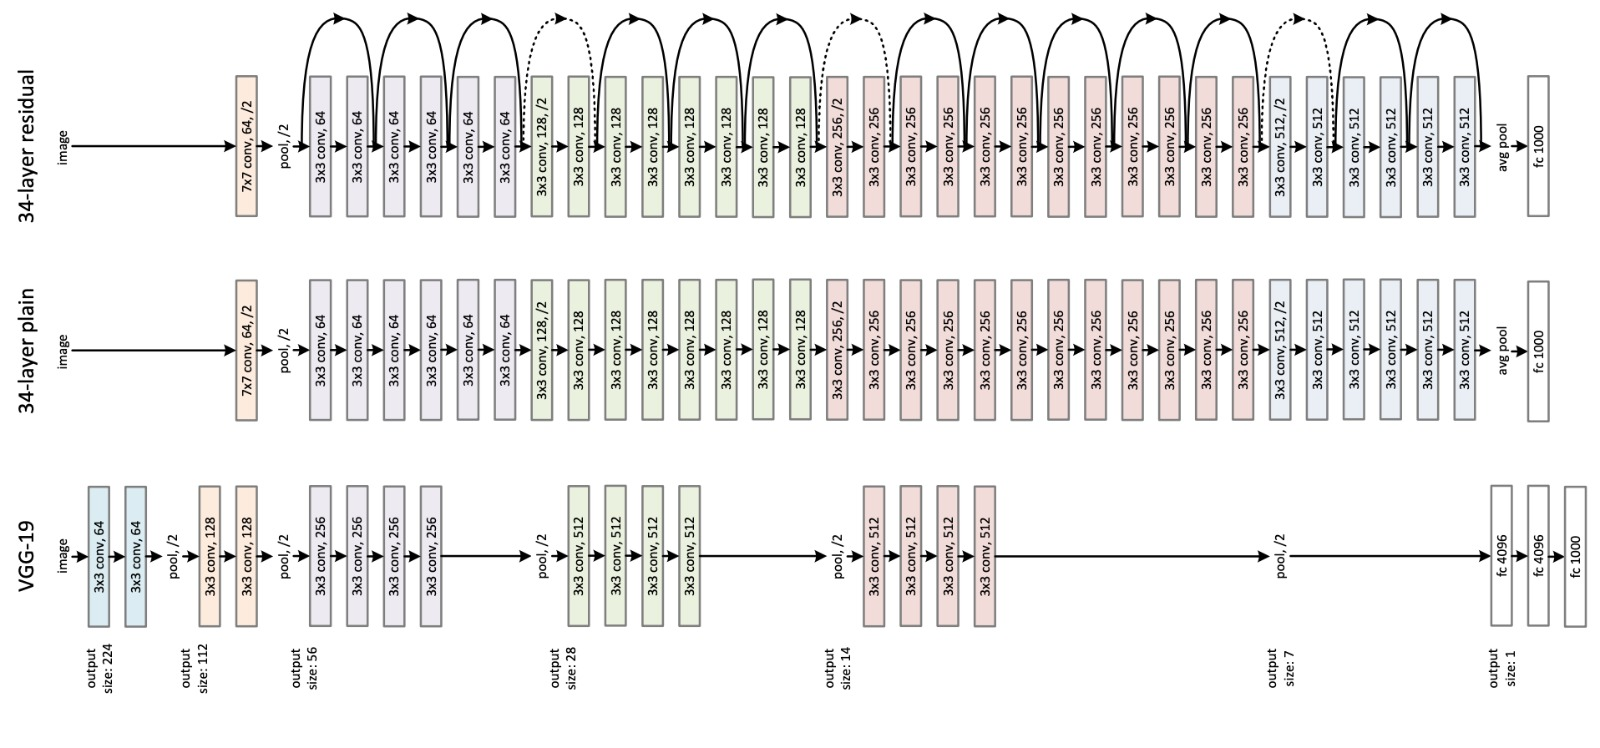

## Training on non-augmented data

In [13]:
# Transforming the input images to match the expected input type for our images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [14]:
def load_image_files(image_dir):
    image_files = []
    labels = []

    for file_name in os.listdir(image_dir):
        if file_name.endswith(".jpg") or file_name.endswith(".png"):
            file_path = os.path.join(image_dir, file_name)
            image_files.append(file_path)

            # 0 indicates cat, and 1 indicates dog
            if "cat" in file_name.lower():
                labels.append(0)
            elif "dog" in file_name.lower():
                labels.append(1)

    return image_files, labels

In [15]:
train_images, train_labels = load_image_files(TRAIN_DIR)
test_images, test_labels = load_image_files(TEST_DIR)

In [16]:
# Creating a custom dataset
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform # input image pre-processing

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [17]:
# Create DataLoaders
train_dataset = CustomImageDataset(train_images, train_labels, transform)
test_dataset = CustomImageDataset(test_images, test_labels, transform)

train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle = True)

In [18]:
model.config.num_labels = 2
num_features = model.classifier[-1].in_features

model.classifier[-1] = nn.Linear(num_features, 2)
model.classifier

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2048, out_features=2, bias=True)
)

In [19]:
def reinitialize_model_weights(model):
    """
    This function iterates over all layers of the model and re-initializes the model.
    By using this we ensure that we are training the entire model from scratch and not just finetuning it to our dataset
    """
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d):
            init.kaiming_normal_(layer.weight, mode = 'fan_out', nonlinearity = 'relu')
            if layer.bias is not None:
                init.zeros_(layer.bias)

        elif isinstance(layer, nn.Linear):
            init.xavier_normal_(layer.weight)
            if layer.bias is not None:
                init.zeros_(layer.bias)

        elif isinstance(layer, nn.BatchNorm2d):
            init.ones_(layer.weight)# Scale to 1
            init.zeros_(layer.bias)# Bias to 0

# Reinitialize weights of the ResNet model
reinitialize_model_weights(model)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-6)
criterion = torch.nn.CrossEntropyLoss() # using CrossEntropyLoss for binary classification

In [21]:
num_epochs = 15
accuracy1 = []
f11 = []
precision1 = []
recall1 = []
loss1 = []
test_loss1 = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")
    loss1.append(avg_train_loss)

    # Validatation
    model.eval()
    running_corrects = 0
    all_val_preds = []
    all_val_labels = []
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            loss = criterion(outputs.logits, labels)
            running_val_loss += loss.item()

            _, preds = torch.max(outputs.logits, 1)
            running_corrects += torch.sum(preds == labels).item()
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_val_labels, all_val_preds)
    precision = precision_score(all_val_labels, all_val_preds, average='binary')
    recall = recall_score(all_val_labels, all_val_preds, average='binary')
    f1 = f1_score(all_val_labels, all_val_preds, average='binary')

    accuracy1.append(accuracy)
    precision1.append(precision)
    recall1.append(recall)
    f11.append(f1)
    test_loss1.append(running_val_loss / len(test_dataloader))

    print(f"Test loss: {(running_val_loss/len(test_dataloader)):.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")
    print("-------------------------------")

Epoch [1/15], Loss: 0.7608
Test loss: 0.7701
Validation Accuracy: 0.5000
Validation Precision: 0.5000
Validation Recall: 1.0000
Validation F1 Score: 0.6667
-------------------------------
Epoch [2/15], Loss: 0.6530
Test loss: 0.7039
Validation Accuracy: 0.5000
Validation Precision: 0.5000
Validation Recall: 1.0000
Validation F1 Score: 0.6667
-------------------------------
Epoch [3/15], Loss: 0.5915
Test loss: 0.6911
Validation Accuracy: 0.4643
Validation Precision: 0.4545
Validation Recall: 0.3571
Validation F1 Score: 0.4000
-------------------------------
Epoch [4/15], Loss: 0.5382
Test loss: 0.7172
Validation Accuracy: 0.3929
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1 Score: 0.0000
-------------------------------
Epoch [5/15], Loss: 0.4926
Test loss: 0.6840
Validation Accuracy: 0.6071
Validation Precision: 0.6364
Validation Recall: 0.5000
Validation F1 Score: 0.5600
-------------------------------
Epoch [6/15], Loss: 0.4559
Test loss: 0.7608
Validation Accu

In [22]:
# Saving the trained model
model.save_pretrained(r"non_augmented_train_data")
processor.save_pretrained("non_augmented_train_data")

['non_augmented_train_data/preprocessor_config.json']

## Training the model on non-augmented as well as augmented images

In [23]:
processor2 = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model2 = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

In [24]:
# Adding 2 classification heads
model2.config.num_labels = 2
num_features = model2.classifier[-1].in_features

model2.classifier[-1] = nn.Linear(num_features, 2)
model2.classifier

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2048, out_features=2, bias=True)
)

In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = processor2.image_mean, std=processor2.image_std)
])

In [26]:
reinitialize_model_weights(model2)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model2.parameters(), lr = 1e-5)
criterion = torch.nn.CrossEntropyLoss() # using CrossEntropyLoss for binary classification

In [28]:
def load_image_files2(image_dirs):
    image_files = []
    labels = []

    for image_dir in image_dirs:
        for file_name in os.listdir(image_dir):
            if file_name.endswith(".jpg") or file_name.endswith(".png"):
                file_path = os.path.join(image_dir, file_name)
                image_files.append(file_path)

                # 0 indicates cat, and 1 indicates dog
                if "cat" in file_name.lower():
                    labels.append(0)
                elif "dog" in file_name.lower():
                    labels.append(1)

    return image_files, labels

In [29]:
train_images2, train_labels2 = load_image_files2([TRAIN_DIR, AUG_DIR])
test_images2, test_labels2 = load_image_files2([TEST_DIR])

In [30]:
# Creating DataLoaders for augmented + non-augmented data
train_dataset2 = CustomImageDataset(train_images2, train_labels2, transform)
test_dataset2 = CustomImageDataset(test_images2, test_labels2, transform)

train_dataloader2 = DataLoader(train_dataset2, batch_size = 8, shuffle = True)
test_dataloader2 = DataLoader(test_dataset2, batch_size = 8, shuffle = False)

In [31]:
num_epochs = 15

accuracy2 = []
precision2 = []
recall2 = []
f12 = []
loss2 = []
test_loss2 = []

for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0

    # Training loop
    for images, labels in train_dataloader2:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model2(images)
        loss = criterion(outputs.logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_dataloader2)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")
    loss2.append(avg_train_loss)

    # Validation
    model2.eval()
    all_val_preds = []
    all_val_labels = []
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model2(images)

            loss = criterion(outputs.logits, labels)
            running_val_loss += loss.item()

            _, preds = torch.max(outputs.logits, 1)
            running_corrects += torch.sum(preds == labels).item()
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    # Computing metrics
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_precision = precision_score(all_val_labels, all_val_preds, average='binary')
    val_recall = recall_score(all_val_labels, all_val_preds, average='binary')
    val_f1 = f1_score(all_val_labels, all_val_preds, average = 'binary')

    # Append the metrics to the lists
    accuracy2.append(val_accuracy)
    precision2.append(val_precision)
    recall2.append(val_recall)
    f12.append(val_f1)
    test_loss2.append(running_val_loss / len(test_dataloader))

    # Print the results
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    print("-------------------------------")

Epoch [1/15], Loss: 1.0735
Validation Accuracy: 0.5000
Validation Precision: 0.5000
Validation Recall: 1.0000
Validation F1 Score: 0.6667
-------------------------------
Epoch [2/15], Loss: 0.7819
Validation Accuracy: 0.5000
Validation Precision: 0.5000
Validation Recall: 1.0000
Validation F1 Score: 0.6667
-------------------------------
Epoch [3/15], Loss: 0.6804


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5000
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1 Score: 0.0000
-------------------------------
Epoch [4/15], Loss: 0.6631


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5000
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1 Score: 0.0000
-------------------------------
Epoch [5/15], Loss: 0.6985


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.5000
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1 Score: 0.0000
-------------------------------
Epoch [6/15], Loss: 0.6525
Validation Accuracy: 0.4286
Validation Precision: 0.3333
Validation Recall: 0.1429
Validation F1 Score: 0.2000
-------------------------------
Epoch [7/15], Loss: 0.6277
Validation Accuracy: 0.6071
Validation Precision: 0.5789
Validation Recall: 0.7857
Validation F1 Score: 0.6667
-------------------------------
Epoch [8/15], Loss: 0.6313
Validation Accuracy: 0.5714
Validation Precision: 0.6667
Validation Recall: 0.2857
Validation F1 Score: 0.4000
-------------------------------
Epoch [9/15], Loss: 0.6089
Validation Accuracy: 0.5714
Validation Precision: 0.5714
Validation Recall: 0.5714
Validation F1 Score: 0.5714
-------------------------------
Epoch [10/15], Loss: 0.6155
Validation Accuracy: 0.6071
Validation Precision: 0.5714
Validation Recall: 0.8571
Validation F1 Score: 0.6857
-------------------------------
Epoch 

## Results

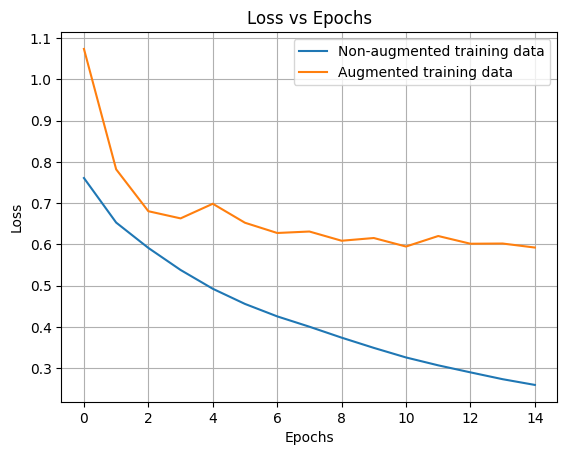

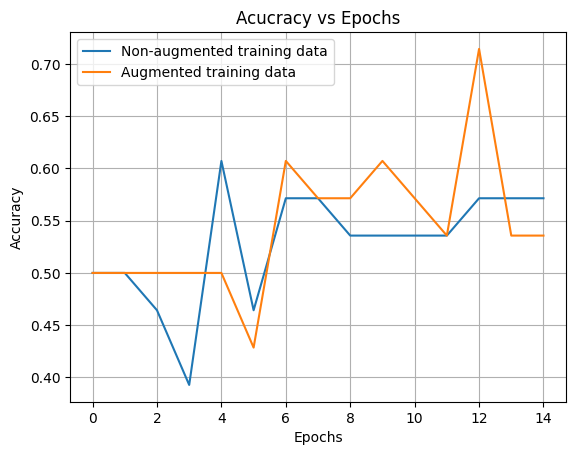

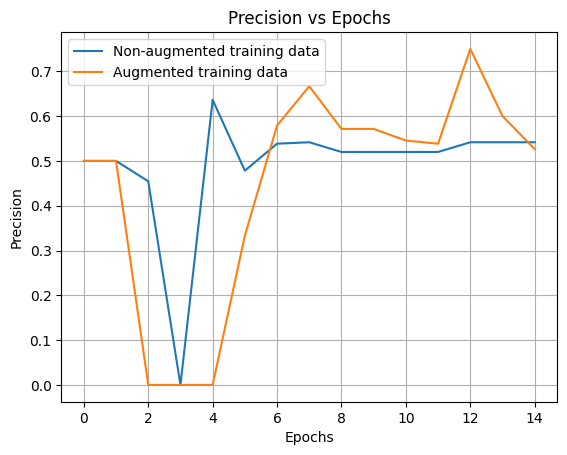

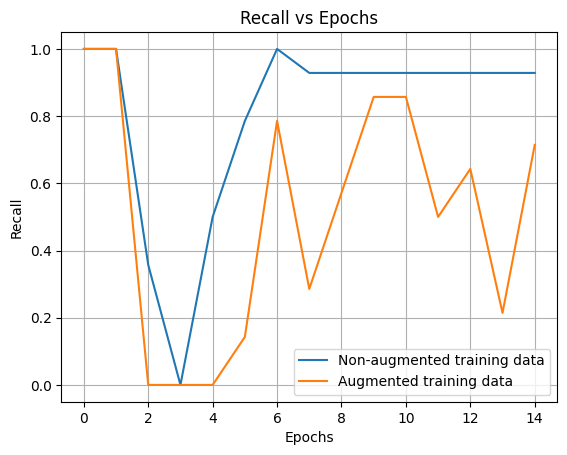

<function matplotlib.pyplot.show(close=None, block=None)>

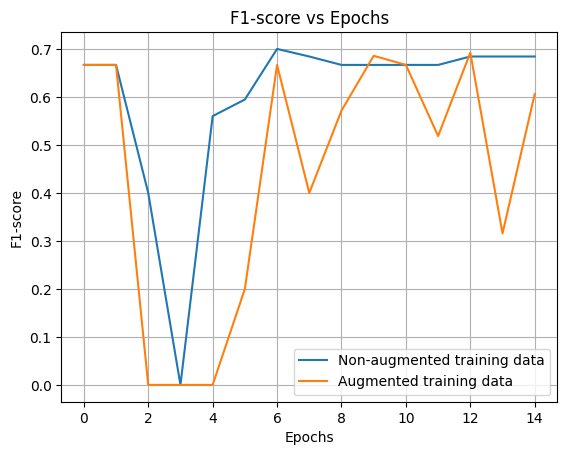

In [32]:
# Plotting the graphs
plt.title("Loss vs Epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.grid(True)
plt.plot(loss1, label = "Non-augmented training data")
plt.plot(loss2, label = "Augmented training data")
plt.legend()
plt.show()

plt.title("Acucracy vs Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.grid(True)
plt.plot(accuracy1, label = "Non-augmented training data")
plt.plot(accuracy2, label = "Augmented training data")
plt.legend()
plt.show()

plt.title("Precision vs Epochs")
plt.ylabel("Precision")
plt.xlabel("Epochs")
plt.grid(True)
plt.plot(precision1, label = "Non-augmented training data")
plt.plot(precision2, label = "Augmented training data")
plt.legend()
plt.show()

plt.title("Recall vs Epochs")
plt.ylabel("Recall")
plt.xlabel("Epochs")
plt.grid(True)
plt.plot(recall1, label = "Non-augmented training data")
plt.plot(recall2, label = "Augmented training data")
plt.legend()
plt.show()

plt.title("F1-score vs Epochs")
plt.ylabel("F1-score")
plt.xlabel("Epochs")
plt.grid(True)
plt.plot(f11, label = "Non-augmented training data")
plt.plot(f12, label = "Augmented training data")
plt.legend()
plt.show

### Reason for poor metrics
The metrics that we obtained are not as good as we expected them to be. The primary reason for this is the fact that we are reinitializing the model weights, and then we try to train such a large model (~25M trainable parameters) on such a small dataset(112 or 336 samples).

### Impact of augmentation
Additionally, we can also see that the model that we train using augmented images(at 12 epochs) performs better than the model that we train using only the original images on almost all metrics. This is due to the fact that using augmented images for training makes our model more robust.

<b>Below is a comparison of the bias variance trade-off for both the models: </b>

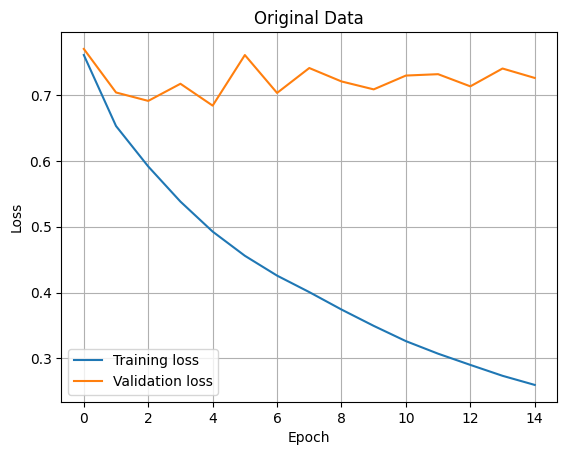

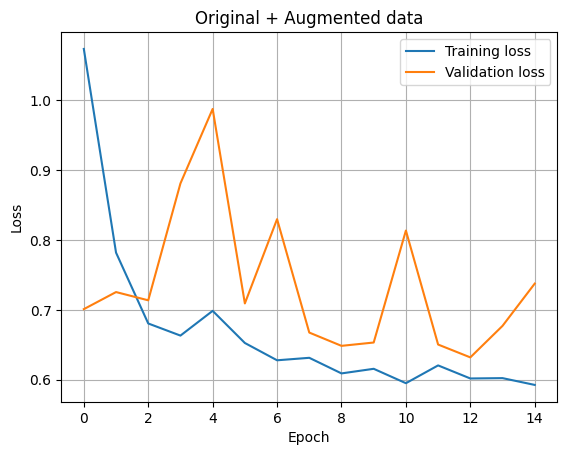

In [33]:
# Original data
plt.title("Original Data")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss1, label = "Training loss")
plt.plot(test_loss1, label = "Validation loss")
plt.legend()
plt.show()

# Original data + augmented
plt.title("Original + Augmented data")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss2, label = "Training loss")
plt.plot(test_loss2, label = "Validation loss")
plt.legend()
plt.show()

From the above plots, we can say that the difference between the train and validation loss is way lower in the case of augmented data compared to that in the case of non-augmented data. <br> <b>Augmentation reduces overfitting(variance).</b>